# IMPORTACIÓN LIBRERIAS NECESARIAS

In [1]:
#importar modulos necesarios
import dipy
import nibabel as nib 
import numpy as np
import matplotlib.pyplot as plt

from os.path import expanduser, join
from time import time

from dipy.align.reslice import reslice
from dipy.align import motion_correction

from dipy.core.histeq import histeq
from dipy.core.gradients import gradient_table

from dipy.data import fetch_sherbrooke_3shell, get_fnames, default_sphere

from dipy.denoise.nlmeans import nlmeans
from dipy.denoise.noise_estimate import piesno, estimate_sigma

from dipy.direction import peaks_from_model

from dipy.io import read_bvals_bvecs
from dipy.io.image import load_nifti, save_nifti, load_nifti_data
from dipy.io.streamline import save_trk
from dipy.io.gradients import read_bvals_bvecs
from dipy.io.stateful_tractogram import Space, StatefulTractogram

from dipy.reconst.shm import CsaOdfModel
from dipy.reconst.csdeconv import auto_response_ssst

from dipy.segment.mask import median_otsu

from dipy.tracking import utils
from dipy.tracking.streamline import Streamlines
from dipy.tracking.local_tracking import LocalTracking
from dipy.tracking.stopping_criterion import ThresholdStoppingCriterion

from dipy.viz import window, actor, has_fury, colormap

Generalmente se utilizan tres tipos de archivos, un archivo Nifti con los datos ponderados por difusión y dos archivos de texto, uno con valores b y otro con vectores b.

Asignación de las rutas a variables


RUTAS CARO

In [2]:
#para el sujeto 001 ponemos la ruta de la imagen DTI
fdwi = ( r'bids_project\subjects\sub-001\dti\sub-001_dti.nii.gz')
print(fdwi)
fbval = ( r'bids_project\subjects\sub-001\dti\sub-001_dti.bval')
print(fbval)
fbvec = (r'bids_project\subjects\sub-001\dti\sub-001_dti.bvec')
print(fbvec)


bids_project\subjects\sub-001\dti\sub-001_dti.nii.gz
bids_project\subjects\sub-001\dti\sub-001_dti.bval
bids_project\subjects\sub-001\dti\sub-001_dti.bvec


RUTAS STHEFANY


In [ ]:
#para el sujeto 001 ponemos la ruta de la imagen DTI
fdwi = ( r'bids_project\subjects\sub-001\dti\sub-001_dti.nii.gz')
print(fdwi)
fbval = ( r'bids_project\subjects\sub-001\dti\sub-001_dti.bval')
print(fbval)
fbvec = (r'bids_project\subjects\sub-001\dti\sub-001_dti.bvec')
print(fbvec)


bids_project\subjects\sub-001\dti\sub-001_dti.nii.gz
bids_project\subjects\sub-001\dti\sub-001_dti.bval
bids_project\subjects\sub-001\dti\sub-001_dti.bvec


# RECONOCIMIENTO DE LOS DATOS

Luego se cargan los conjuntos de datos de dMRI. Para ello se utiliza una biblioteca de Python llamada nibabel, permite leer y escribir formatos de archivos específicos de neuroimagen.                                                                     data: es una matriz 4D donde las primeras 3 dimensiones son las coordenadas de vóxel i, j, k y la última dimensión es el número de volúmenes no ponderados (S0) y ponderados por difusión.

In [3]:
data, affine, img = load_nifti(fdwi, return_img=True)
print(data.shape)

FileNotFoundError: No such file or no access: 'bids_project/subjects/sub-001/dti/sub-001_dti.nii.gz'

También se pueden ver las dimensiones de cada vóxel:

In [ ]:
print(img.header.get_zooms()[:3])

(2.0, 2.0, 2.0)


Podemos visualizar rápidamente los resultados usando matplotlib . Por ejemplo, mostremos aquí los cortes axiales medios del volumen 0 y el volumen 10.

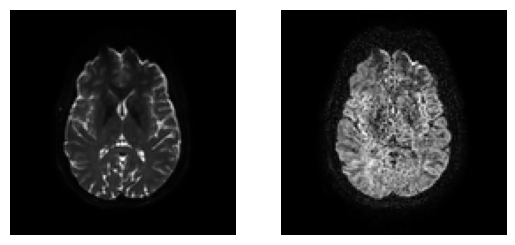

<Figure size 640x480 with 0 Axes>

In [ ]:
axial_middle = data.shape[2] // 2
plt.figure('Showing the datasets')
plt.subplot(1, 2, 1).set_axis_off()
plt.imshow(data[:, :, axial_middle, 0].T, cmap='gray', origin='lower')
plt.subplot(1, 2, 2).set_axis_off()
plt.imshow(data[:, :, axial_middle, 10].T, cmap='gray', origin='lower')
plt.show()
plt.savefig('data.png', bbox_inches='tight')

# CARGA VALORES Y VECTORES B

El siguiente paso es cargar los valores b y los vectores b desde el disco usando la función read_bvals_bvecs.En DIPY, utilizamos un objeto llamado GradientTableque contiene todos los parámetros específicos de adquisición, por ejemplo, valores b, vectores b, tiempos y otros. Para crear este objeto puedes usar la función gradient_table. Finalmente, puede usar gtab(el objeto GradientTable) para mostrar información sobre los parámetros de adquisición.

In [ ]:
bvals, bvecs = read_bvals_bvecs(fbval, fbvec)
gtab = gradient_table(bvals, bvecs)
print(gtab.info)

B-values shape (113,)
         min 0.000000
         max 1000.000000
B-vectors shape (113, 3)
          min -0.989732
          max 1.000000

None


También puedes ver los valores b usando:

In [ ]:
print(gtab.bvals)

[   0. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000.]


In [ ]:
print(gtab.bvecs)

[[ 0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.86265e-09 -2.98023e-08  1.00000e+00]
 [-7.15461e-01  5.62011e-01  4.15041e-01]
 [-6.80290e-01 -5.88040e-01  4.37510e-01]
 [ 2.88070e-01  8.72411e-01  3.94860e-01]
 [ 5.72811e-01 -6.82741e-01  4.53600e-01]
 [ 8.95438e-01  1.22400e-01  4.28029e-01]
 [-4.13491e-01  8.98452e-01  1.47680e-01]
 [ 5.30120e-01 -3.15150e-01  7.87180e-01]
 [ 6.61731e-01  7.17421e-01  2.17760e-01]
 [-6.48220e-01  2.31998e-03  7.61450e-01]
 [-2.47311e-01 -8.86903e-01  3.90181e-01]
 [ 9.42202e-01 -3.02441e-01  1.44170e-01]
 [ 2.58901e-02 -9.89732e-01  1.40570e-01]
 [ 4.18800e-02  4.64620e-01  8.84519e-01]
 [-9.30220e-01 -2.83200e-01  2.33430e-01]
 [-1.01550e-01 -4.26180e-01  8.98920e-01]
 [-3.92819e-01  5.62089e-01  7.27839e-01]
 [ 5.04638e-01  3.48499e-01  7.89867e-01]
 [ 7.20768e-01 -3.22189e-01  6.13748e-01]
 [ 7.60790e-01 -6.46490e-01  5.70100e-02]
 [-4.85601e-01 -4.37751e-01  7.56681e-01]
 [-7.87396e-02  7.04706e-01  7.05116e-01]
 [ 2.27749e-01 -9.37507e-01  2.630

O, por ejemplo, los 10 primeros vectores b usando:

In [ ]:
print(gtab.bvecs[:10, :])

[[ 0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.86265e-09 -2.98023e-08  1.00000e+00]
 [-7.15461e-01  5.62011e-01  4.15041e-01]
 [-6.80290e-01 -5.88040e-01  4.37510e-01]
 [ 2.88070e-01  8.72411e-01  3.94860e-01]
 [ 5.72811e-01 -6.82741e-01  4.53600e-01]
 [ 8.95438e-01  1.22400e-01  4.28029e-01]
 [-4.13491e-01  8.98452e-01  1.47680e-01]
 [ 5.30120e-01 -3.15150e-01  7.87180e-01]
 [ 6.61731e-01  7.17421e-01  2.17760e-01]]


gtab se puede utilizar para saber qué parte de los datos son los volúmenes S0 (volúmenes que corresponden a valores b de 0).Aquí solo se ve 1 S0, como podemos verificar observando las dimensiones de los S0.

In [ ]:
S0s = data[:, :, :, gtab.b0s_mask]
print(S0s.shape)

(128, 128, 90, 1)


# PREPROCESAMIENTO

En el contexto de las imágenes de resonancia magnética de difusión (dMRI), un tamaño de voxel isotrópico significa que las dimensiones del voxel son iguales en todas las direcciones del espacio, es decir, tienen las mismas dimensiones en el eje x, y, y z. Esto es importante porque simplifica el procesamiento de los datos y permite una interpretación más sencilla de las medidas de difusión. 
En nuestro caso si lo es ya que Voxel size: (1.0, 1.0, 1.0) para la T1 y (2.0, 2.0, 2.0) Para la imagen DTI. Por lo tanto no se requiere rebanar el conjunto de datos

Usamos aquí un conjunto de datos para mostrar los principios básicos.

In [ ]:
fimg = (r'bids_project\subjects\sub-001\anat\sub-001_T1w.nii.gz')

Cargamos la imagen, el afín de la imagen y el tamaño del vóxel. El afín es la matriz de transformación que asigna las coordenadas de la imagen a las coordenadas mundiales (mm). Luego, imprimimos la forma del volumen.

In [ ]:
data, affine, voxel_size = load_nifti(fimg, return_voxsize=True)

print(f"Data size: {data.shape}")
print(f"Voxel size: {voxel_size}")

Data size: (211, 256, 256)
Voxel size: (1.0, 1.0, 1.0)


**Corrección de movimiento entre volúmenes en conjuntos de datos DWI**

Durante una adquisición de imágenes de resonancia magnética de difusión (dMRI), el sujeto puede experimentar movimiento, que puede manifestarse como desplazamientos o rotaciones entre los diferentes volúmenes adquiridos en la secuencia de imágenes. Este movimiento es inevitable y puede ser causado por factores como el movimiento involuntario del sujeto, la respiración o el pulso del corazón.
La desalineación entre los volúmenes en un conjunto de datos de dMRI puede ser problemática porque puede introducir artefactos en los datos y afectar la calidad de las imágenes. Por ejemplo, puede causar distorsiones en las imágenes o afectar la precisión de las medidas de difusión.
Una forma común de abordar este problema es realizar un registro (o alineación) en cada volumen adquirido con respecto a un volumen de referencia, que generalmente es un volumen con un valor b igual a cero (b = 0). Los volúmenes con un valor b igual a cero se adquieren sin gradiente de difusión, por lo que son menos sensibles al movimiento y proporcionan una buena referencia para alinear los otros volúmenes en la secuencia.
El registro de cada volumen con respecto al volumen de referencia implica ajustar la posición y orientación de cada volumen para que se superpongan lo más cercanamente posible al volumen de referencia. Esto se hace típicamente utilizando métodos de registro espacial que encuentran la transformación geométrica óptima para alinear dos imágenes.

In [ ]:
#para el sujeto 001 ponemos la ruta de la imagen DTI
fdwi = ( r'bids_project\subjects\sub-001\dti\sub-001_dti.nii.gz')
print(fdwi)
fbval = ( r'bids_project\subjects\sub-001\dti\sub-001_dti.bval')
print(fbval)
fbvec = (r'bids_project\subjects\sub-001\dti\sub-001_dti.bvec')
print(fbvec)

bids_project\subjects\sub-001\dti\sub-001_dti.nii.gz
bids_project\subjects\sub-001\dti\sub-001_dti.bval
bids_project\subjects\sub-001\dti\sub-001_dti.bvec


In [ ]:
data, affine = load_nifti(fdwi)
bvals, bvecs = read_bvals_bvecs(fbval, fbvec)
#imprimimos valores
print("Forma de los datos de imagen de resonancia magnética de difusión (dMRI):", data.shape)
print("Cantidad de valores b:", len(bvals))
print("Cantidad de vectores b:", len(bvecs))

Forma de los datos de imagen de resonancia magnética de difusión (dMRI): (128, 128, 90, 113)
Cantidad de valores b: 113
Cantidad de vectores b: 113


Hay 113 volúmenes en total en tus datos. Esto significa que cada volumen de los datos tiene una resolución de 128x128 píxeles en un corte axial, con 90 cortes axiales en total, y hay 113 volúmenes en la secuencia.   
En cuanto a la cantidad de valores b y vectores b, hay 113 de cada uno, lo que significa que hay un valor b y un vector b correspondiente para cada volumen en la secuencia.
Dado esto se evidencia que hay suficientes volúmenes para realizar una corrección de movimiento. DIPY no recomienda realizar una corrección de movimiento con menos de 10 volúmenes.

In [ ]:
# Aquí el número de volúmenes se reduce desde el volumen 5 hasta el final
data_small = data[..., 5:]
bvals_small = bvals[5:]
bvecs_small = bvecs[5 :]
gtab = gradient_table(bvals_small, bvecs_small)

Se reducen los volumenes de 113 a 3  seleccionando solo los primeros 3 volúmenes de los datos (data[..., :3]) y los correspondientes valores b (bvals[:3]) y vectores b (bvecs[:3]). Luego, se crea una nueva tabla de gradientes (gtab) utilizando los nuevos valores b y vectores b.

Si el interés es capturar cambios rápidos en la difusión de agua o eventos de corta duración en el cerebro, es importante conservar una resolución temporal suficiente en los datos. 
Áreas del cerebro con alta densidad de fibras nerviosas o con estructuras anatómicas complejas pueden requerir más volúmenes para capturar adecuadamente la variabilidad en la difusión.


In [ ]:
data_corrected, reg_affines = motion_correction(data_small, gtab, affine)

Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
Optimizing level 2 [max iter

ValueError: shape mismatch: value array of shape (4,4,107) could not be broadcast to indexing result of shape (4,4,108)

Se aplica la corrección de movimiento a los datos reducidos (data_small) utilizando la tabla de gradientes (gtab) y la información de transformación espacial (affine). La función motion_correction es responsable de realizar el registro de los volúmenes con respecto al volumen de referencia (b = 0) para corregir cualquier movimiento entre ellos.
("Optimizing level 1 [max iter: 1000]", "Optimizing level 0 [max iter: 100]", etc.) son mensajes de progreso o estado de la optimización que se está realizando durante la corrección de movimiento.

Como este es un análisis de tractografía que requiere un cálculo rápido o un procesamiento más ligero, podría ser útil reducir el número de volúmenes. Sin embargo, si el interés es un análisis más detallado que requiera una alta resolución temporal o espacial, podría ser necesario conservar más volúmenes.

**Estimación de ruido usando PIESNO**

PIESNO (Probabilistic Identification and Estimation of Noise) es un método utilizado para estimar el nivel de ruido en las imágenes ponderadas por difusión.
Con este método, se puede detectar la desviación estándar del ruido de la imagen ponderada por difusión. Una vez que se identifican las regiones de ruido, PIESNO estima la desviación estándar del ruido en estas áreas, lo que proporciona una medida cuantitativa del nivel de ruido en las imágenes:

El método PIESNO funciona en dos pasos:

1- Primero, encuentra vóxeles que probablemente sean vóxeles de fondo. Estos vóxeles tienen intensidades ponderadas por difusión muy similares (hasta algo de ruido) en la cuarta dimensión del conjunto de datos. Los vóxeles de materia blanca, materia gris o LCR tienen intensidades de difusión que varían bastante en diferentes direcciones.
2) A partir de estos vóxeles de fondo estimados y el número de bobinas de entrada N, PIESNO encuentra qué sigma es cada gaussiano de cada uno de los N bobinas habrían generado el Rician observado (N=1) o Chi no central (N>1) perfil de ruido distribuido en los conjuntos de datos.

PIESNO hace una suposición importante: se supone que la desviación estándar del ruido gaussiano es uniforme. El ruido es uniforme en múltiples ubicaciones de cortes o en múltiples imágenes de la misma ubicación.


In [ ]:
#para el sujeto 001 ponemos la ruta de la imagen DTI
fdwi = ( r'bids_project\subjects\sub-001\dti\sub-001_dti.nii.gz')
print(fdwi)
fbval = ( r'bids_project\subjects\sub-001\dti\sub-001_dti.bval')
print(fbval)
fbvec = (r'bids_project\subjects\sub-001\dti\sub-001_dti.bvec')
print(fbvec)

bids_project\subjects\sub-001\dti\sub-001_dti.nii.gz
bids_project\subjects\sub-001\dti\sub-001_dti.bval
bids_project\subjects\sub-001\dti\sub-001_dti.bvec


In [ ]:
#cargamos los datos y el afín:
data, affine = load_nifti(fdwi)

c:\Users\sthef\AppData\Local\Programs\Python\Python311\Lib\site-packages\dipy\denoise\noise_estimate.py:252: RuntimeWarning: divide by zero encountered in divide
  s = sum_m2 / (2 * K * sigma**2)
c:\Users\sthef\AppData\Local\Programs\Python\Python311\Lib\site-packages\dipy\denoise\noise_estimate.py:252: RuntimeWarning: invalid value encountered in divide
  s = sum_m2 / (2 * K * sigma**2)


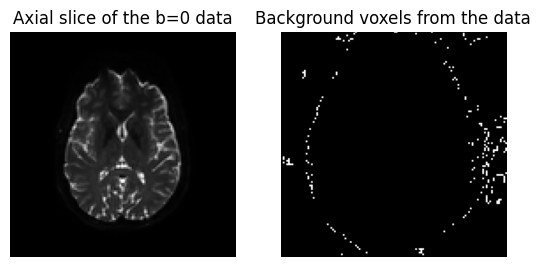

In [ ]:
#Función piesno para estimar el nivel de ruido en los datos de imagen de resonancia magnética de difusión.
#Se especifica N=4 para indicar que se utilizaron 4 grupos distintos de canales receptores durante la adquisición de datos
sigma, mask = piesno(data, N=4, return_mask=True) #devuelve una máscara que identifica los píxeles que contienen principalmente ruido en los datos

axial = data[:, :, data.shape[2] // 2, 0].T #corresponde aproximadamente al centro del volumen
#Se crea una máscara de píxeles de ruido seleccionando la misma posición axial de la máscara devuelta por PIESNO.

axial_piesno = mask[:, :, data.shape[2] // 2].T #Se transpone la selección para que la orientación sea adecuada para su visualización
#Se crea una figura con dos subtramas, una para mostrar la imagen axial original y otra para 
#mostrar la máscara de PIESNO que identifica los píxeles de ruido.
fig, ax = plt.subplots(1, 2)
ax[0].imshow(axial, cmap='gray', origin='lower')
ax[0].set_title('Axial slice of the b=0 data')
ax[1].imshow(axial_piesno, cmap='gray', origin='lower')
ax[1].set_title('Background voxels from the data')
for a in ax:
    a.set_axis_off()
plt.savefig('piesno.png', bbox_inches='tight')

Se muestra el corte axial medio de la imagen b=0 (izquierda) y los vóxeles de fondo estimados (derecha) utilizados para estimar la desviación estándar del ruido.

In [ ]:
save_nifti('mask_piesno.nii.gz', mask.astype(np.uint8), affine)

print('The noise standard deviation is sigma = ', sigma)
print('The std of the background is =',np.std(data[mask[..., :].astype(bool)]))

The noise standard deviation is sigma =  [3.1810913 3.1810913 3.1810913 3.1810913 3.1810913 3.1810913 3.1810913
 3.1810913 3.1810913 3.1810913 3.1810913 0.        0.        3.1810913
 3.1810913 0.        3.1810913 3.1810913 3.1810913 3.1810913 3.1810913
 3.1810913 3.1810913 0.        3.1810913 3.1810913 3.1810913 3.1810913
 3.1810913 6.3621826 3.1810913 3.1810913 3.1810913 3.1810913 3.1810913
 3.1810913 3.1810913 3.1810913 3.1810913 3.1810913 3.1810913 3.1810913
 3.1810913 3.1810913 3.1810913 3.1810913 3.1810913 0.        0.
 3.1810913 3.1810913 3.1810913 3.1810913 3.1810913 3.1810913 3.1810913
 3.1810913 3.1810913 3.1810913 3.1810913 3.1810913 3.1810913 3.1810913
 3.1810913 3.1810913 3.1810913 3.1810913 3.1810913 3.1810913 3.1810913
 3.1810913 9.543274  3.1810913 3.1810913 3.1810913 3.1810913 3.1810913
 3.1810913 3.1810913 3.1810913 3.1810913 3.1810913 3.1810913 9.543274
 9.543274  3.1810913 3.1810913 6.3621826 6.3621826 6.3621826]
The std of the background is = 7.264775229704395


*Desviación estándar del ruido (sigma):*
La desviación estándar del ruido proporciona una medida de la variabilidad del ruido en las imágenes.
En este caso, se muestra una lista de desviaciones estándar para diferentes volúmenes de datos.
Los valores más altos de desviación estándar del ruido indican mayor variabilidad del ruido en los datos.

*Desviación estándar del fondo (The std of the background is):*
La desviación estándar del fondo representa la variabilidad de la señal de fondo en las imágenes, que incluye tanto el ruido como la señal de fondo real.
Una desviación estándar más alta del fondo puede indicar mayor variabilidad en la señal de fondo, lo que puede afectar la calidad de los datos y el rendimiento de los algoritmos de análisis.

**Eliminación de ruido de imágenes utilizando medios no locales (NLMEANS)**

Esta comparación data > 1500 crea una máscara binaria donde los píxeles con valores mayores que 1500 se asignan como Verdadero (True), mientras que los píxeles con valores iguales o menores que 1500 se asignan como Falso (False). Se establece este valor ya que se buscan valores de intensidad más altos en la imagen T1. Por ejemplo, la materia blanca o la corteza cerebral, que generalmente tienen valores de intensidad más altos en las imágenes T1.
Eliminación de ruido o artefactos, ya que os valores de píxeles muy bajos pueden corresponder a ruido o artefactos en la imagen. Al aplicar esta comparación, se pueden eliminar o minimizar los efectos de estos valores no deseados.

In [ ]:
#para el sujeto 001 ponemos la ruta de la imagen DTI
ft1 = ( r'bids_project\subjects\sub-001\anat\sub-001_T1w.nii.gz')
print(ft1)
fbval = ( r'bids_project\subjects\sub-001\dti\sub-001_dti.bval')
print(fbval)
fbvec = (r'bids_project\subjects\sub-001\dti\sub-001_dti.bvec')
print(fbvec)
data, affine = load_nifti(ft1)
mask = data > 1500
print("vol size", data.shape)

bids_project\subjects\sub-001\anat\sub-001_T1w.nii.gz
bids_project\subjects\sub-001\dti\sub-001_dti.bval
bids_project\subjects\sub-001\dti\sub-001_dti.bvec
vol size (211, 256, 256)


Antes de aplicar el filtro Non-Local Means (NLM), es necesario estimar la desviación estándar del ruido presente en la imagen. Esta desviación estándar del ruido es un parámetro crucial para el funcionamiento del filtro NLM, ya que determina cómo de agresivamente se aplicará el filtrado en cada píxel de la imagen.

El valor de N indica el número de bobinas utilizadas para adquirir el conjunto de datos. Se utilizó un valor de N = 32.
Esto indica que el conjunto de datos se adquirió utilizando una bobina de cabeza de 32 matrices en un escáner GE de 3 Tesla.

In [ ]:
sigma = estimate_sigma(data, N=32)
#estimate_sigma: Estimación de la desviación estándar de parches locales.
t = time()
den = nlmeans(data, sigma=sigma, mask=mask, patch_radius=1, block_radius=2, rician=True)
#Medios no locales para eliminar el ruido de imágenes 3D y 4D
print("total time", time() - t)

total time 2.6363446712493896


t: inicia un temporizador, time() que devuelve el tiempo actual en segundos desde un punto de referencia específico y la función nlmeans() se utiliza para aplicar el filtro Non-Local Means (NLMeans) a los datos de imagen.
*data:* Los datos de la imagen a los que se aplicará el filtro.

*sigma:* La desviación estándar del ruido en la imagen, que se ha estimado previamente.

*mask:* Una máscara opcional que indica las regiones de la imagen en las que se aplicará el filtrado. Los píxeles marcados como verdadero en la máscara serán considerados en el proceso de filtrado, mientras que los píxeles marcados como Falso se ignorarán.

*patch_radius:* El radio del parche utilizado para calcular la similitud entre píxeles. Un valor mayor incluirá un área más grande alrededor de cada píxel en el cálculo de la similitud.

*block_radius:* El radio del bloque utilizado para agrupar píxeles similares para el filtrado ponderado.

*rician:* Un indicador booleano que especifica si el ruido en la imagen debe modelarse como riciano.

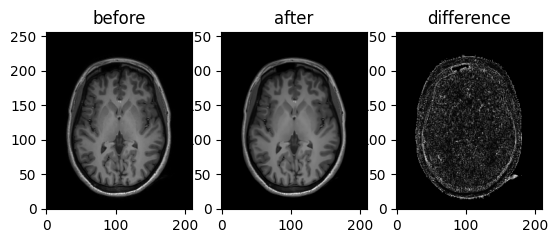

In [ ]:
#Esta posición se utiliza para acceder a la porción central del volumen de datos a lo largo del eje axial.
axial_middle = data.shape[2] // 2
#before contiene la imagen original antes del filtrado.
#after contiene la imagen denoised después de aplicar el filtro NLMeans.
before = data[:, :, axial_middle].T
after = den[:, :, axial_middle].T
difference = np.abs(after.astype(np.float64) - before.astype(np.float64)) #da una medida de la cantidad de cambio introducido por el filtrado.
#Establece a cero todas las diferencias que corresponden a píxeles fuera de la región de interés especificada por la máscara.
difference[~mask[:, :, axial_middle].T] = 0
fig, ax = plt.subplots(1, 3)
ax[0].imshow(before, cmap='gray', origin='lower')
ax[0].set_title('before')
ax[1].imshow(after, cmap='gray', origin='lower')
ax[1].set_title('after')
ax[2].imshow(difference, cmap='gray', origin='lower')
ax[2].set_title('difference')
plt.savefig('denoised.png', bbox_inches='tight')
save_nifti('denoised.nii.gz', den, affine)

Mostrando un corte axial antes (izquierda) y después (derecha) de la eliminación de ruido de NLMEANS

**Segmentación cerebral con median_otsu**

La segmentación cerebral con median_otsu es un proceso en el que se utiliza el método de umbralización adaptativa conocido como "median_otsu" para segmentar la imagen de resonancia magnética cerebral y extraer la información cerebral relevante. 

*median_otsu* es un algoritmo de umbralización adaptativa utilizado para segmentar imágenes médicas, como imágenes de resonancia magnética (MRI). Este método combina la mediana y la desviación estándar de la intensidad de píxeles para determinar un umbral de segmentación. Una vez aplicado se obtiene una máscara binaria que identifica las regiones de la imagen que corresponden al cerebro. Esta máscara se puede utilizar para "enmascarar" la imagen original, lo que significa que solo se retendrá la información dentro de las regiones identificadas como cerebrales, mientras que el resto de la imagen se eliminará o se ignorará.

In [ ]:
#para el sujeto 001 ponemos la ruta de la imagen DTI
fdwi = ( r'bids_project\subjects\sub-001\dti\sub-001_dti.nii.gz')
print(fdwi)
fbval = ( r'bids_project\subjects\sub-001\dti\sub-001_dti.bval')
print(fbval)
fbvec = (r'bids_project\subjects\sub-001\dti\sub-001_dti.bvec')
print(fbvec)
data, affine = load_nifti(ft1)
data = np.squeeze(data)
b0_mask, mask = median_otsu(data, median_radius=2, numpass=1)

bids_project\subjects\sub-001\dti\sub-001_dti.nii.gz
bids_project\subjects\sub-001\dti\sub-001_dti.bval
bids_project\subjects\sub-001\dti\sub-001_dti.bvec


*median_radius* controla el tamaño del kernel utilizado para calcular la mediana de las intensidades de los píxeles. Un valor más alto puede ser útil para suavizar la imagen, mientras que un valor más bajo puede capturar mejor los detalles finos.

*num_pass* especifica el número de pasadas del algoritmo. Un valor más alto puede mejorar la precisión de la segmentación, pero a costa de un tiempo de ejecución más largo.

Devuelve dos salidas: b0_mask, que contiene los datos del cerebro segmentados, y mask, que es la máscara binaria del cerebro.

In [ ]:
fname = 'se_1.5t'
save_nifti(fname + '_binary_mask.nii.gz', mask.astype(np.float32), affine)
save_nifti(fname + '_mask.nii.gz', b0_mask.astype(np.float32), affine)

También se necesita la matriz de afinidad affine, que describe la orientación y el espaciado de los píxeles en la imagen.

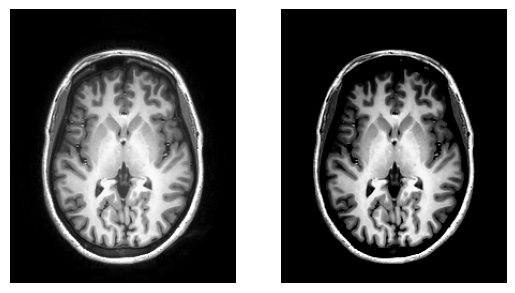

In [ ]:
sli = data.shape[2] // 2
plt.figure('Brain segmentation')
plt.subplot(1, 2, 1).set_axis_off()
plt.imshow(histeq(data[:, :, sli].astype('float')).T, cmap='gray', origin='lower')
plt.subplot(1, 2, 2).set_axis_off()
plt.imshow(histeq(b0_mask[:, :, sli].astype('float')).T, cmap='gray', origin='lower')
plt.savefig(f'{fname}_median_otsu.png', bbox_inches='tight')

In [ ]:
b0_mask_crop, mask_crop = median_otsu(data, median_radius=4, numpass=4, autocrop=True)

El autocorte es un proceso en el que se recorta automáticamente el exceso de fondo alrededor del cerebro segmentado. Esto puede ser útil para eliminar partes de la imagen que no son relevantes para el análisis, lo que reduce el tamaño del archivo y mejora la eficiencia del procesamiento.

In [ ]:
save_nifti(fname + '_binary_mask_crop.nii.gz', mask_crop.astype(np.float32), affine)
save_nifti(fname + '_mask_crop.nii.gz', b0_mask_crop.astype(np.float32),affine)

**Seguimiento de fibras locales**

Enfoque utilizado para modelar fibras de materia blanca mediante la creación de líneas de corriente a partir de información direccional local. Si se conoce la direccionalidad local de un tramo/segmento de vía, se puede integrar a lo largo de esas direcciones para construir una representación completa de esa estructura. El seguimiento de fibras locales se utiliza ampliamente en el campo de la resonancia magnética de difusión porque es simple y robusto.

**Para realizar el seguimiento de fibra local, se necesitan tres cosas:**

1. Un método para obtener direcciones a partir de un conjunto de datos de difusión.

2. Un método para identificar cuándo debe detenerse el seguimiento.

3. Un conjunto de semillas a partir del cual empezar a rastrear.

In [ ]:
# Define las rutas de tus propios archivos
hardi_fname = r'bids_project\subjects\sub-001\dti\sub-001_dti.nii.gz'
hardi_bval_fname = r'bids_project\subjects\sub-001\dti\sub-001_dti.bval'
hardi_bvec_fname = r'bids_project\subjects\sub-001\dti\sub-001_dti.bvec'
label_fname = r'bids_project\subjects\sub-001\dti\sub-001_dti.nii.gz'

# Ahora puedes continuar con el resto del código
data, affine, hardi_img = load_nifti(hardi_fname, return_img=True)
labels = load_nifti_data(label_fname)
bvals, bvecs = read_bvals_bvecs(hardi_bval_fname, hardi_bvec_fname)
gtab = gradient_table(bvals, bvecs)

Este conjunto de datos proporciona un mapa de etiquetas en el que todos los tejidos de materia blanca están etiquetados como 1 o 2. Creemos una máscara de materia blanca para restringir el seguimiento a la materia blanca.

In [ ]:
white_matter = (labels == 1) | (labels == 2)

In [ ]:
print("Forma de datos:", data.shape)
print("Forma de la máscara:", white_matter.shape)

Forma de datos: (128, 128, 90, 113)
Forma de la máscara: (128, 128, 90, 113)


In [ ]:
# Imprimir los valores únicos de las etiquetas
unique_labels = np.unique(labels)
print("Valores únicos de las etiquetas:", unique_labels)

# También puedes imprimir la cantidad de etiquetas únicas
print("Cantidad de etiquetas únicas:", len(unique_labels))

Valores únicos de las etiquetas: [0.00000000e+00 9.63525200e+00 1.92705040e+01 ... 3.94370864e+04
 3.94467217e+04 3.94563569e+04]
Cantidad de etiquetas únicas: 4082


In [ ]:
response, ratio = auto_response_ssst(gtab, data, roi_radii=10, fa_thr=0.7)
csa_model = CsaOdfModel(gtab, sh_order_max=6)
csa_peaks = peaks_from_model(csa_model, data, default_sphere, relative_peak_threshold=.8,min_separation_angle=45,
                             mask=white_matter)

ValueError: Mask is not the same shape as data.